In [66]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pysentani

In [67]:
survey = pd.read_excel('../data-clean/sentani-merged-cleaned-2015-06-10.xlsx',na_values=[''])
print('number of entries =', len(survey))
print('number of columns =', len(survey.columns))

number of entries = 1184
number of columns = 274


In [68]:
job_survey = pd.get_dummies(survey['job'])

survey_ls = [survey, job_survey]

survey = pd.concat(survey_ls, axis=1)

In [69]:
survey['electricity_expenditure_monthly'] = pysentani.elec_expenditure_monthly(survey)
survey['electricity_expenditure_monthly_log'] = survey['electricity_expenditure_monthly'].dropna().replace(0, 1)
survey['electricity_expenditure_monthly_log'] = np.log10(survey['electricity_expenditure_monthly_log'])
survey['income_monthly'] = pysentani.income_monthly(survey)
survey['access_type'] = pysentani.access_type(survey)
survey['income_monthly'] = survey['income_monthly'].replace(0, 1)
survey['income_monthly_log'] = np.log10(survey['income_monthly'])

In [70]:
df = pd.crosstab(survey['access_type'],survey['farmer'])
df[1]['PLN_grid']

193

In [71]:
household_survey = survey[survey['demand_point'] == 'household']
household_survey.rename(columns={'access_type': 'Access Type',
                                 'farmer': 'Farmers',
                                 'fisherman': 'Fishermen',
                                 'private': 'Private',
                                 'day_labor_or_other': 'Day Labor (or Other)',
                                 'government': 'Government',
                                 'business': 'Business',
                                 'skilled_labor': 'Skilled Labor',
                                 'sell_handy_crafts': 'Sell Handy Crafts',
                                 'artist': 'Artists'},
                                 inplace = True)

household_survey.replace(to_replace = {'Access Type': {'PLN_grid': 'PLN Grid',
                                                       'community_microgrid': 'Community Microgrid',
                                                       'PLN_microgrid': 'PLN Microgrid',
                                                       'no_access': 'No Access'}},inplace = True)

hh_series = pd.value_counts(household_survey['village_name'])

job_series = ['Farmers',
              'Fishermen',
              'Private',
              'Day Labor (or Other)',
              'Government',
              'Business',
              'Skilled Labor',
              'Sell Handy Crafts',
              'Artists']
job_ls = []

for jobs in job_series:

    at_series = ['PLN Grid','PLN Microgrid','Community Microgrid','No Access'] 
    temp_job_df = pd.crosstab(household_survey['Access Type'],household_survey[jobs])
    
    for ats in at_series:
        #percent_ownership = (temp_app_df[1.0][ats]/(temp_app_df[1.0][ats] + temp_app_df[0.0][ats])) * 100
        job_ls.append({'Access Type':ats,'Job':jobs,'Employed':temp_job_df[1][ats]})


job_df = pd.DataFrame(job_ls)
job_df

/Applications/anaconda/envs/sotolab/lib/python3.4/site-packages/pandas/core/frame.py:2524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
/Applications/anaconda/envs/sotolab/lib/python3.4/site-packages/pandas/core/generic.py:2790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


,Access Type,Employed,Job
0,PLN Grid,190,Farmers
1,PLN Microgrid,39,Farmers
2,Community Microgrid,13,Farmers
3,No Access,132,Farmers
4,PLN Grid,111,Fishermen
5,PLN Microgrid,40,Fishermen
6,Community Microgrid,25,Fishermen
7,No Access,74,Fishermen
8,PLN Grid,99,Private
9,PLN Microgrid,7,Private


[None, None, None, None]

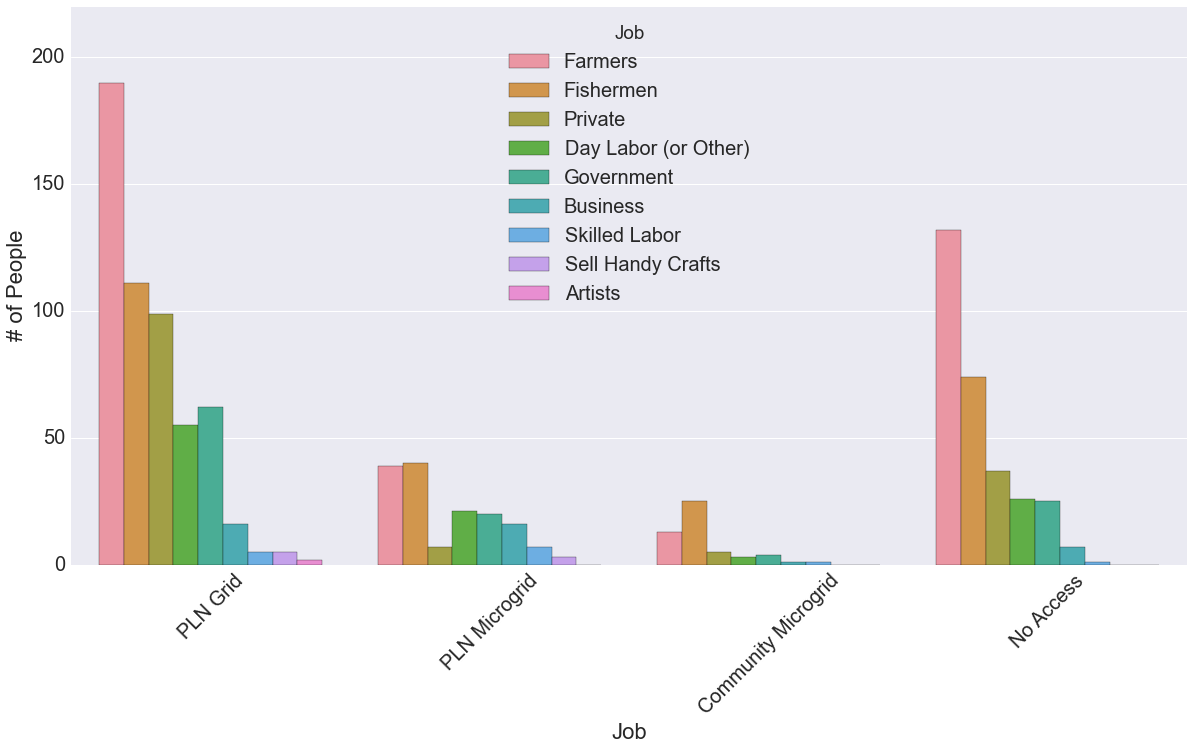

In [72]:
sns.set(font_scale = 2)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

fig, ax = plt.subplots()

ax = sns.barplot(x="Access Type", y="Employed", hue="Job", data=job_df)

#ax.set_xticklabels(app_name_ls)
ax.set(xlabel='Job', ylabel='# of People')

plt.ylim(0,220)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)

#fig.savefig('test.pdf')


In [73]:
survey.dropna()
corrMatrix= survey.corr()

corrMatrix.loc[:,:] =  np.tril(corrMatrix, k=-1) # borrowed from Karl D's answer

already_in = set()
result = []
for col in corrMatrix:
    perfect_corr = corrMatrix[col][corrMatrix[col] >= .99][corrMatrix[col] < 1].index.tolist()
    if perfect_corr and col not in already_in:
        already_in.update(set(perfect_corr))
        perfect_corr.append(col)
        result.append(perfect_corr)

In [75]:
#Above, might be interesting if I could figure out how to get columns that weren't all nulls, or I could figure out a
#way to separate out possible causal relationships, rather than cooincidental coorelations.  